# Data Exploration
This notebook provides a structured exploration of the **TMDB (The Movie Database) dataset**, which contains movie meta data including textual data analysis of `overview`, `genres` labels, and `release_date`. The notebook is organized into two main chapters:

---

## 1. **Dataset Overview and Initial Exploration**
In the first part, the dataset is loaded from a JSON Lines file and thoroughly inspected to assess its structure. Special attention is given to the key columns relevant for downstream analysis, such as `overview`, `genres`, and `release_date`.
Approximately **80% of all available columns** are **visually explored**, including distribution plots, missing value checks, and structural consistency. This ensures a solid data foundation before applying any NLP methods.

---

## 2. **Textual Data Analysis with NLP**
The second part applies a series of NLP techniques to extract deeper linguistic and semantic insights from the cleaned film overviews. It consists of **two focused analyses**, each visualized to support interpretation:

- **Temporal Keyword Trends**
  → TF-IDF is applied to different cinematic eras, and the most distinctive terms are displayed using **word clouds** to show how film language changes over time.

- **Inter-Genre Similarity Analysis**
  → Genre-level TF-IDF vectors (unigrams + bigrams) are compared via **cosine similarity**, visualized in a **heatmap with hierarchical clustering** to uncover thematic and linguistic proximity between genres.

---


# Imports & one-time notebook setup
This section loads all required libraries and sets up the environment for text preprocessing, analysis, and visualization.

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import re
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nlp = spacy.load("en_core_web_sm")

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, leaves_list

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

from ipywidgets import Output, Accordion
from IPython.display import display

sns.set_theme(style="darkgrid", context="talk")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---

# 1. Dataset Overview and Initial Exploration

## Importing the Movie Dataset

In [2]:
df_all = pd.read_json('../data/all_data.json', lines=True)

## Overview and Structure

In [3]:
print("\n--- Data Overview ---")
print(df_all.info())
print("\n--- First 5 rows ---")
print(df_all.head())
print("\n--- Missing Values ---")
print(df_all.isnull().sum().sort_values(ascending=False))


--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571381 entries, 0 to 571380
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    571381 non-null  int64  
 1   title                 571381 non-null  object 
 2   genres                400016 non-null  object 
 3   original_language     571381 non-null  object 
 4   overview              469028 non-null  object 
 5   popularity            571381 non-null  float64
 6   production_companies  264060 non-null  object 
 7   release_date          528796 non-null  object 
 8   budget                571381 non-null  int64  
 9   revenue               571381 non-null  int64  
 10  runtime               541947 non-null  float64
 11  status                571381 non-null  object 
 12  tagline               84506 non-null   object 
 13  vote_average          571381 non-null  float64
 14  vote_count            571381 

To get an initial understanding of the dataset, we first inspect its structure using `df_all.info()`, which reveals the **number of entries**, **data types**, and **missing values per column**. The `df_all.head()` command shows the **first five rows** to give a quick glimpse of the actual content. Finally, `df_all.isnull().sum().sort_values(ascending=False)` summarizes **missing values across all columns**, helping to identify **potential issues for data cleaning**.

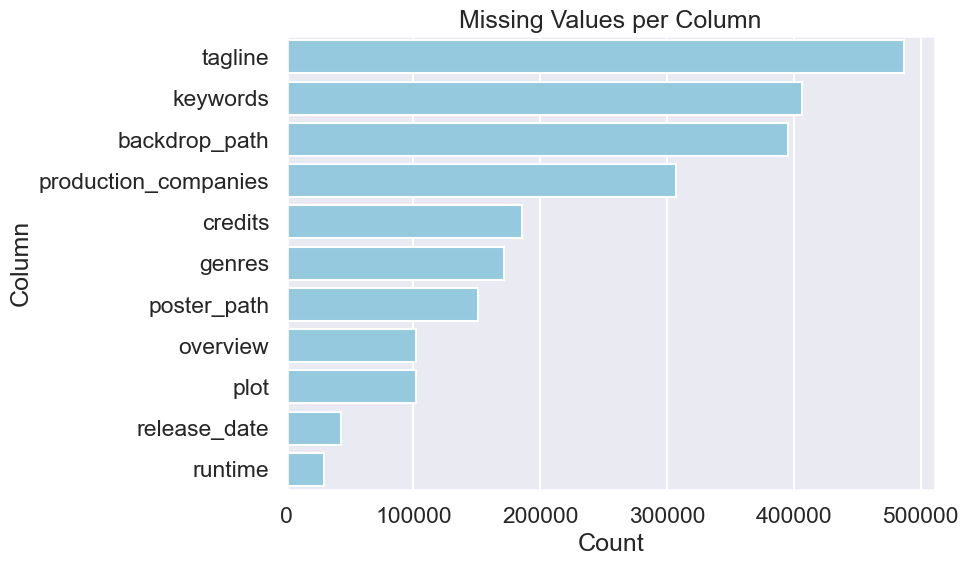

In [4]:
missing = df_all.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=missing.values, y=missing.index, color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Count')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

The chart shows the **number of missing values per column** in our movie dataset.
Text-heavy fields like `tagline`, `keywords`, and `backdrop_path` are sparsely populated, whereas core attributes such as `runtime` and `release_date` are largely complete.

## Temporal Analysis

In [5]:
released_df = df_all[df_all['status'].str.lower() == 'released'].copy()
released_df['release_date'] = pd.to_datetime(released_df['release_date'], errors='coerce')
valid_dates = released_df['release_date'].dropna()

print("Temporal Coverage of Movies with the status: Released")
print(f"From: {valid_dates.min().date()} To: {valid_dates.max().date()}")

Temporal Coverage of Movies with the status: Released
From: 1874-12-09 To: 2025-01-24


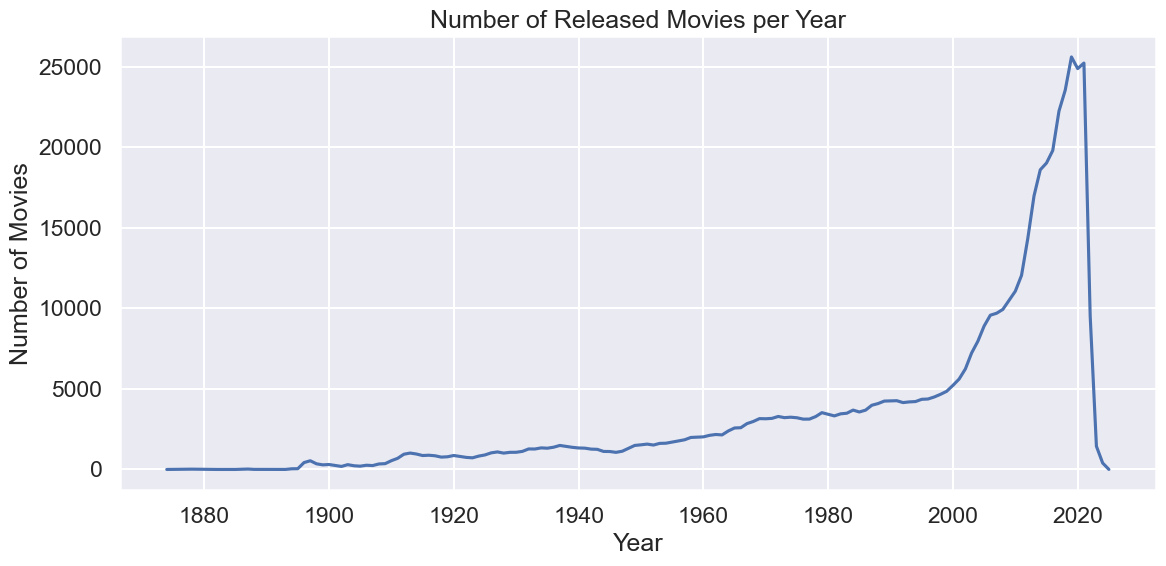

In [6]:
valid_years = valid_dates.dt.year

plt.figure(figsize=(12, 6))
valid_years.value_counts().sort_index().plot(kind='line')
plt.title('Number of Released Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

The timeline stays almost **flat until the early 1900s**, rises gradually, and then **soars after 2000**, peaking at **≈ 25 k releases around 2020**.
A sudden drop follows, hinting at either a **gap in data coverage** or postponed reporting.
What triggered this sharp decline, an actual slowdown in filmmaking, or the ripple effects of the **pandemic era**?

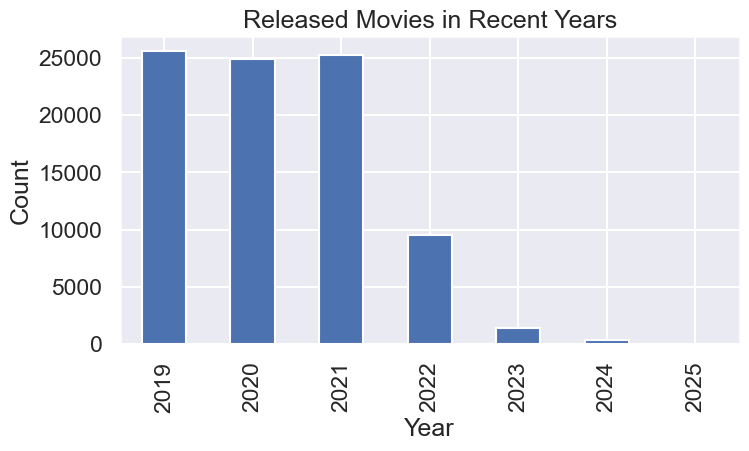

In [7]:
recent = valid_dates[valid_dates.dt.year >= 2019].dt.year
recent.value_counts().sort_index().plot(kind='bar', figsize=(8, 4))
plt.title("Released Movies in Recent Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

A closer look at the **recent‐year breakdown** shows that counts remain **steady from 2019 to 2021** and only **collapse after 2022**.
Since the pandemic window (2020–2021) does *not* coincide with the drop, the missing titles are more plausibly a **data-coverage artefact**, e.g. delayed metadata updates, rather than a genuine halt in global film production.

## Genre Analysis

In [8]:
df_all['genres'].value_counts()

genres
Documentary                                            78982
Drama                                                  57783
Comedy                                                 37924
Animation                                              17544
Music                                                  15666
                                                       ...  
Adventure-Western-Action-Romance-Drama                     1
Science Fiction-Western-TV Movie-Adventure-Thriller        1
Thriller-Drama-TV Movie-Mystery                            1
Adventure-Drama-Action-Thriller-Mystery                    1
Animation-Drama-Mystery-Adventure                          1
Name: count, Length: 10226, dtype: int64

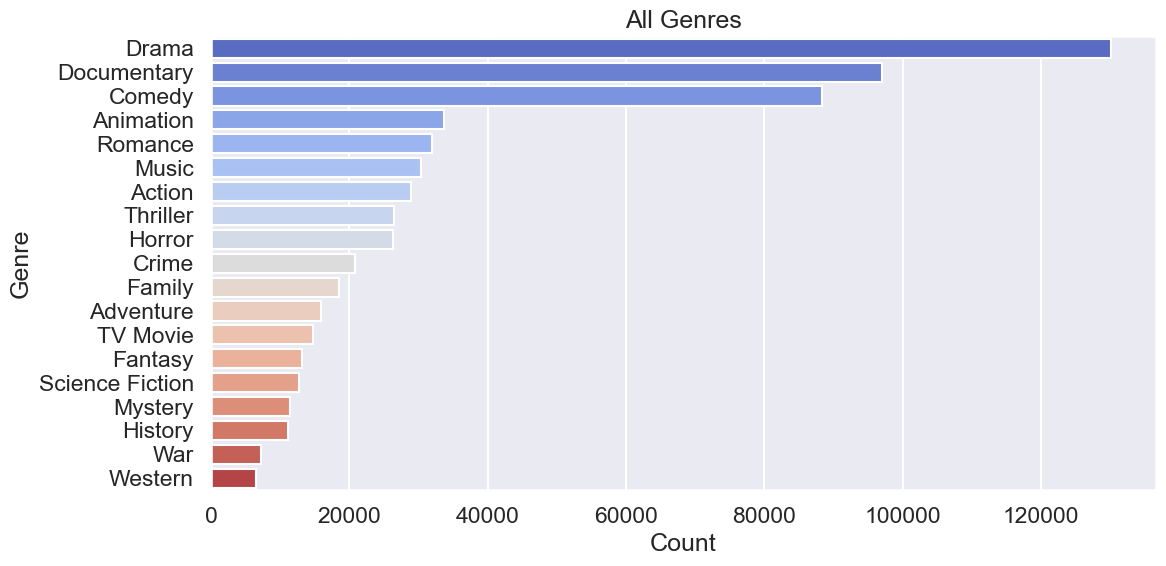

In [9]:
genres_raw = df_all['genres'].copy()
genres_split = genres_raw.str.split('-')
genres_exploded = genres_split.explode().reset_index(drop=True)
top_genres = genres_exploded.value_counts()
top_genres_df = top_genres.reset_index()
top_genres_df.columns = ['genre', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_genres_df,
    x='count',
    y='genre',
    hue='genre',
    palette='coolwarm',
    dodge=False,
    legend=False
)
plt.title('All Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

After **splitting** the multi-genre strings and **exploding** them into single tags, the bar chart reveals a **heavy skew toward Drama**, with **Documentary**, **Comedy**, and **Animation** trailing behind.
Niche labels such as **Western** and **War** occur an order of magnitude less often, signalling a pronounced **class imbalance** that any genre-aware model must address through weighting or resampling strategies.

## Revenue and Budget

In [12]:
filtered_df = df_all[
    (df_all['budget'] >= 1e5) &
    (df_all['budget'] <= 5e8) &
    (df_all['revenue'] >= 1e4) &
    (df_all['revenue'] <= 3e9)
].copy()

fig = px.scatter(
    filtered_df,
    x='budget',
    y='revenue',
    hover_name='title',
    log_x=True,
    log_y=True,
    opacity=0.6,
    title='Film Budget and Revenue (Cleaned)',
    labels={
        'budget': 'Budget in USD',
        'revenue': 'Revenue in USD'
    }
)

fig.add_shape(
    type='line',
    x0=1e5, y0=1e5,
    x1=5e8, y1=5e8,
    line=dict(color='red', dash='dash'),
)

fig.update_layout(
    height=600,
    width=900,
    template='plotly_dark',
    xaxis=dict(tickformat="$.2s", title_font=dict(size=14)),
    yaxis=dict(tickformat="$.2s", title_font=dict(size=14)),
    title_font=dict(size=18),
    margin=dict(l=60, r=40, t=60, b=60)
)

fig.show()

After **filtering out implausible values** (budgets < 100 k or > 500 M, revenues < 10 k or > 3 B), the log–log scatter reveals a **clear positive trend**: larger budgets tend to yield higher revenues.
Most titles cluster between **1 M–50 M** in budget and **1 M–200 M** in revenue, while a thin tail of big-budget blockbusters exceeds the $200 M mark on both axes.
The spread below the diagonal highlights cases where high spend did **not** translate into proportional earnings, underscoring the financial risk inherent in film production.

## Ratings and Popularity

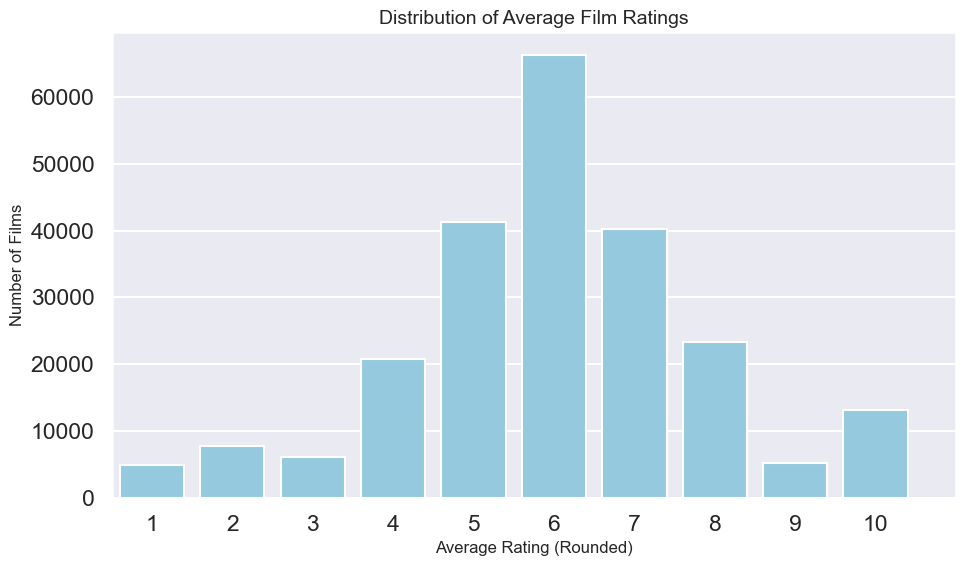

In [13]:
valid_ratings = df_all[df_all['vote_average'] > 0].copy()
valid_ratings['vote_avg_rounded'] = valid_ratings['vote_average'].round().astype(int)
vote_counts = valid_ratings['vote_avg_rounded'].value_counts().sort_index()

full_range = range(1, 11)
vote_counts = vote_counts.reindex(full_range, fill_value=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=vote_counts.index, y=vote_counts.values, color='skyblue')

plt.xlabel('Average Rating (Rounded)', fontsize=12)
plt.ylabel('Number of Films', fontsize=12)
plt.title('Distribution of Average Film Ratings', fontsize=14)
plt.xticks(ticks=range(0, 11))
plt.tight_layout()
plt.show()

After filtering out zero-vote titles and **rounding each `vote_average` to the nearest integer**, the histogram shows a **pronounced peak at rating 6**, with ratings 5 and 7 trailing behind.
Extremes are rare: scores **1–3** and **9–10** make up only a small fraction of the catalogue.
The near-normal shape implies that most films cluster around a **“mediocre-to-good”** perception, while very poor or stellar titles remain outliers.

## Language Distribution

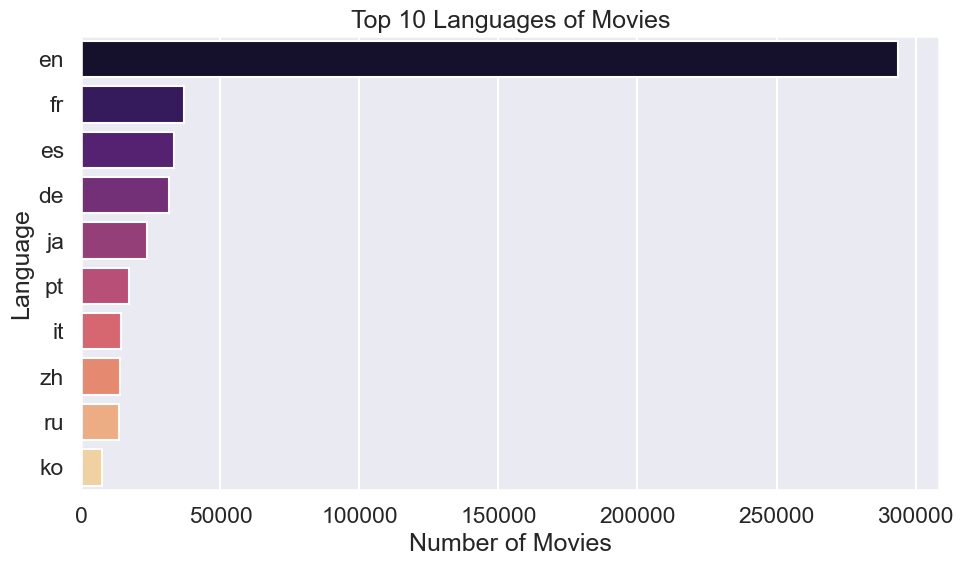

In [14]:
language_counts = df_all['original_language'].value_counts().head(10)
lang_df = language_counts.reset_index()
lang_df.columns = ['language', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=lang_df,
    x='count',
    y='language',
    hue='language',
    palette='magma',
    dodge=False,
    legend=False
)

plt.title('Top 10 Languages of Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Language')
plt.tight_layout()
plt.show()

The chart counts the **`original_language`** tag, revealing a strong prevalence of **English-origin films** and smaller clusters from **French, Spanish, German**, and several Asian markets.
Because every textual field in this dataset is already **translated to English**, these codes do **not** affect downstream NLP processing; they merely signal a film’s **production origin**.
Thus, the plot helps gauge how well different national industries are represented and where cultural coverage may be sparse.

## Overview Length Analysis

In [15]:
print("\nStatistics of overview text length (in words):\n")
overview_lengths = df_all['overview'].dropna().apply(lambda x: len(str(x).split()))
print(overview_lengths.describe())


Statistics of overview text length (in words):

count    469028.000000
mean         47.094205
std          35.229815
min           0.000000
25%          21.000000
50%          37.000000
75%          65.000000
max         226.000000
Name: overview, dtype: float64


**Metric cheat-sheet**
* **Mean:** the arithmetic average, total word count divided by the number of films.
* **Median (50 %):** the midpoint, half the overviews are shorter, half are longer.
* **Std (standard deviation):** typical spread around the mean; higher values signal more variability.
* **25 % / 75 % quartiles:** boundaries of the middle half of the data (IQR); useful for spotting skew.
* **Min / Max:** the shortest and longest overviews observed in the dataset.

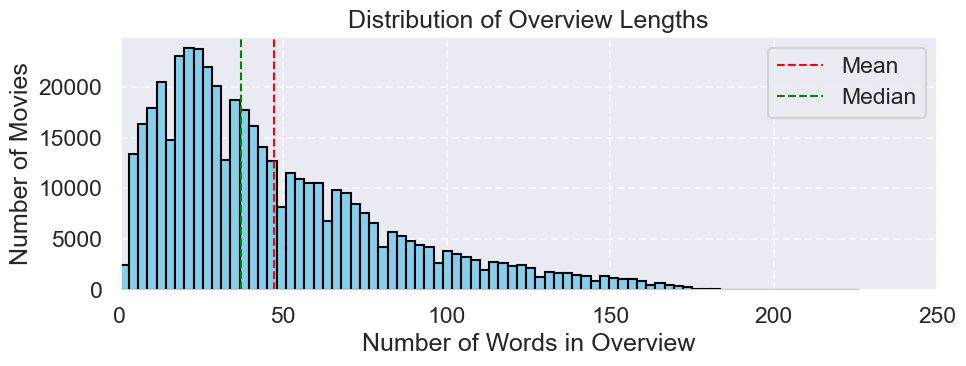

In [16]:
plt.figure(figsize=(10, 4))
plt.hist(overview_lengths, bins=80, color='skyblue', edgecolor='black')
plt.xlim(0, 250)
plt.axvline(overview_lengths.mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean')
plt.axvline(overview_lengths.median(), color='green', linestyle='dashed', linewidth=1.5, label='Median')
plt.title('Distribution of Overview Lengths')
plt.xlabel('Number of Words in Overview')
plt.ylabel('Number of Movies')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The histogram reveals that most **plot overviews** are succinct: the **median is 37 words**, and the **mean (≈ 47 words)** sits slightly higher because a long tail of verbose synopses drags the average rightward.
Three-quarters of summaries stay within **65 words** (75-th percentile), and roughly **90 % remain under 100 words**, with only a few stretching to the **maximum of 226 words**.

## Word Clouds of Keywords

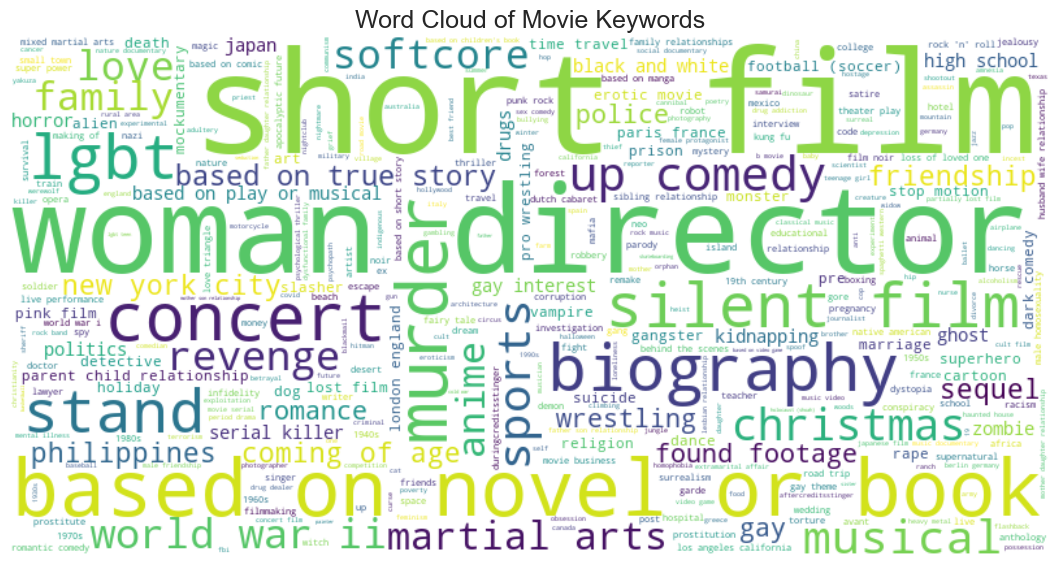

In [17]:
keywords_series = df_all['keywords'].dropna().str.split('-').explode()
keyword_counts = Counter(keywords_series)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=350,
).generate_from_frequencies(keyword_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Keywords')
plt.tight_layout()
plt.show()

The word cloud, built by **splitting the `keywords` column and counting term frequency**, highlights the dataset’s most frequent thematic tags.
Dominant phrases like **“short film,” “woman director,” “based on novel or book,”** and **“murder”** stand out, indicating common production formats, authorship attributes, and narrative motifs.
Mid-sized terms such as **“concert,” “family,” “sports,”** and **“lgbt”** reveal secondary but still substantial topic clusters, while the dense backdrop of smaller words showcases the catalogue’s long-tail diversity.

## Correlation Matrix of Key Numeric Features

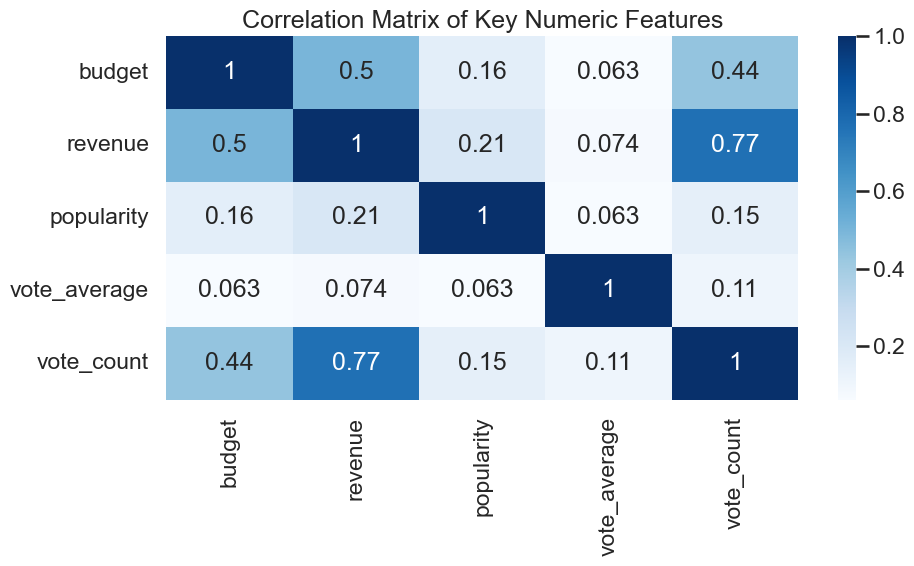

In [18]:
plt.figure(figsize=(10, 6))

correlation_matrix = df_all[['budget', 'revenue', 'popularity', 'vote_average', 'vote_count']].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='Blues'
)

plt.title('Correlation Matrix of Key Numeric Features')
plt.tight_layout()
plt.show()

The heat-map quantifies linear relationships among five numeric features:

* **Budget ↔ Revenue** show a **moderate correlation of 0.50**, confirming that bigger productions tend to earn more.
* **Revenue ↔ Vote Count** is the strongest pair (**0.77**), implying that box-office success draws more user votes.
* **Popularity** correlates weakly with every metric (≤ 0.21), and **vote_average** remains largely independent of the other variables (< 0.11).

---

# 2. Textual Data Analysis with NLP

This chapter explores the narrative structure and semantic characteristics of movie content using Natural Language Processing (NLP) techniques. Two complementary analyses are presented, each leveraging TF-IDF-based representations to uncover patterns in the textual descriptions of movies.

## Overview of Methods

All analyses operate on the `overview` field of the dataset, which contains short plot summaries. The text data is first standardized using a consistent **preprocessing pipeline**, including:

- Lowercasing and punctuation removal
- Tokenization
- Stopword filtering (using NLTK and sklearn)
- Lemmatization (via spaCy’s WordNet model)
- Custom rule-based filtering of named entities, proper noun phrases, and domain-generic terms

After cleaning, the text is structured for two separate tasks:

## 1. Temporal Keyword Trends

Movies are grouped into historical time bins (e.g. *Golden Age*, *Streaming Era*), and the most relevant terms per period are extracted using TF-IDF on **unigrams** and **bigrams**. To improve focus, terms that occur across too many time periods are filtered out. The top 300 keywords per era are visualized as **word clouds**, revealing how themes and language evolve over time, from *silent* and *cartoon* to *covid* and *transgender*.

## 2. Inter-Genre Similarity Analysis

This analysis compares genres based on the vocabulary in their movie overviews. All overviews per genre are merged into one document, and genre-level TF-IDF vectors (combined **unigrams** and **bigrams**) are computed. Named entities and generic terms are filtered using POS tagging and NER. **Cosine similarity** is used to measure semantic proximity, and **hierarchical clustering** reorders the genres. The result is a **heatmap** showing linguistic closeness between genres, e.g., *Thriller–Crime* or *Romance–Drama*, based entirely on descriptive language.


## Configuration Parameters for NLP Pipeline

This configuration dictionary (`CONFIG`) defines key parameters used throughout the TF-IDF-based analyses in this project. These settings control the extraction and filtering of unigrams and bigrams, as well as thresholds for genre inclusion and term frequency limits.

- `unigram_top_n`: Number of top unigrams to consider across the dataset.
- `bigram_top_n`: Number of top bigrams to include.
- `min_genres`: Minimum number of genres a movie must have to be included in the analysis.
- `min_df`: Minimum document frequency threshold – terms appearing in fewer documents are ignored.
- `max_df_unigrams`: Maximum document frequency for unigrams – helps filter out overly common terms.
- `max_df_bigrams`: Same as above, but for bigrams.
- `top_terms_per_genre`: Number of top-scoring TF-IDF terms to keep per genre.
- `tkt_min_df`: Minimum document frequency threshold – terms appearing in fewer documents are ignored.
- `tkt_max_df`: Maximum document frequency – helps filter out overly common terms.

These configuration values are essential for the TF-IDF-based processing in both analyses: **Temporal Keyword Trends** and **Inter-Genre Similarity Analysis**.

In [19]:
CONFIG = {
    "unigram_top_n": 60,
    "bigram_top_n": 45,
    "min_genres": 3,
    "min_df": 0.10,
    "max_df_unigrams": 1.0,
    "max_df_bigrams": 0.8,
    "top_terms_per_genre": 40,
    "tkt_min_df": 1,
    "tkt_max_df": 0.95,
}

## Text Preprocessing

The following code performs basic text preprocessing on the `overview` column of the dataset:

- Converts all text to lowercase.
- Removes all non-alphabetic characters using regular expressions.
- Splits the text into tokens (words).
- Removes common English stop words using NLTK's stopword list.
- Applies lemmatization to reduce words to their base forms using WordNetLemmatizer.

The cleaned text is stored in a new column called `overview_clean`.

These preprocessed overviews serve as the foundation for our two analyses: **Temporal Keyword Trends** and **Inter-Genre Similarity Analysis**.

In [20]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df_all['overview_clean'] = df_all['overview'].apply(preprocess_text)

---

## Analysis 1: Temporal Keyword Trends

### Custom Term Filtering for NLP Analysis

The `should_filter_tkt` function defines **additional filtering rules** to refine the token vocabulary used in the TF-IDF analysis.
It is applied **after basic preprocessing** has already removed stopwords, punctuation, and numeric characters.
This function focuses on:

- Tokens **shorter than 3 characters**
- Terms from a predefined list of **generic, cross-genre unigrams** (`generic_unigrams`)
- Words that do **not** belong to key content-bearing POS tags: **NOUN**, **ADJ**, or **VERB**

By excluding these terms, the function ensures that the vocabulary consists of **semantically relevant and genre-distinctive** words,
enhancing the quality of TF-IDF results.

In [38]:
def should_filter_tkt(token):
    return (
        len(token.text) <= 2 or
        token.text.lower() in generic_unigrams or
        token.pos_ not in {"NOUN", "ADJ", "VERB"}
    )

### TKT TF-IDF Analysis

The `tkt_tfidf_analysis` function performs a time-based TF-IDF analysis on the preprocessed film overviews. It groups movies into predefined historical periods (`time_bins`) and extracts the most relevant unigrams and bigrams for each era.

Key steps:

- Converts the release dates to datetime format and filters out very short texts.
- Iterates through each historical time bin (e.g., *Golden Age*, *Streaming Era*).
- For each time bin, collects the overviews, processes them with spaCy, and filters tokens using `should_filter_tkt`.
- Builds a text corpus of lemmatized tokens per time bin.
- Applies `TfidfVectorizer` to extract n-gram features (1-grams and 2-grams) and compute their importance scores based on TF-IDF.
- Returns a dictionary mapping each time bin to its scored term list.

This temporal analysis helps identify **which words or phrases were most characteristic** of each cinematic era and forms the foundation for the **Temporal Keyword Trends** visualization and interpretation.

In [39]:
time_bins = {
    "1900–1949 (Early Cinema)": (1900, 1949),
    "1950–1969 (Golden Age)": (1950, 1969),
    "1970–1989 (New Hollywood & Blockbuster)": (1970, 1989),
    "1990–2009 (Franchise Era)": (1990, 2009),
    "2010–2025 (Streaming Era)": (2010, 2025)
}

generic_unigrams = set(CONFIG.get("generic_unigrams", [])) if "CONFIG" in globals() else set()
def tkt_tfidf_analysis(df, text_col="overview_clean", date_col="release_date"):
    df = df.copy()

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df[df[text_col].str.len() > 10]

    results = {}

    for label, (start_year, end_year) in time_bins.items():
        subset = df[
            df[date_col].dt.year.between(start_year, end_year) &
            df[text_col].notna()
        ]

        texts = subset[text_col].tolist()
        docs = nlp.pipe(texts, disable=["ner", "parser"])

        corpus = []
        for doc in docs:
            tokens = [token.lemma_.lower() for token in doc if not should_filter_tkt(token)]
            corpus.append(" ".join(tokens))

        if not corpus:
            continue

        vectorizer = TfidfVectorizer(
            ngram_range=(1, 2),
            max_df=CONFIG["tkt_max_df"],
            min_df=CONFIG["tkt_min_df"],
            stop_words=None
        )
        tfidf_matrix = vectorizer.fit_transform(corpus)
        scores = tfidf_matrix.sum(axis=0).A1
        terms = vectorizer.get_feature_names_out()

        tfidf_scores = dict(zip(terms, scores))
        results[label] = tfidf_scores

    return results

tkt_tfidf_results = tkt_tfidf_analysis(df_all)

### Refinement of Temporal TF-IDF Results

The following code refines the raw TF-IDF results from the temporal analysis by applying two additional steps:

1. **`filter_common_terms`**:
   - Removes overly generic terms that appear across too many time periods (default: more than 3).
   - This helps highlight words that are more **characteristic of specific eras**, rather than globally common.

2. **`get_top_n_terms`**:
   - Selects the top **N** (default: 300) highest-scoring TF-IDF terms per time bin.
   - Ensures the final result focuses on the most **informative and distinctive keywords** from each era.

Together, these steps help sharpen the focus of the **Temporal Keyword Trends** by filtering out noise and emphasizing era-defining language patterns.

In [40]:
def filter_common_terms(tfidf_dict, max_epoch_occurrences=3):
    word_occurrences = defaultdict(int)

    for scores in tfidf_dict.values():
        for word in scores:
            word_occurrences[word] += 1

    filtered_dict = {}
    for period, scores in tfidf_dict.items():
        filtered_scores = {
            word: score for word, score in scores.items()
            if word_occurrences[word] <= max_epoch_occurrences
        }
        filtered_dict[period] = filtered_scores

    return filtered_dict

def get_top_n_terms(tfidf_dict, n=300):
    limited_dict = {}
    for period, scores in tfidf_dict.items():
        sorted_terms = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n])
        limited_dict[period] = sorted_terms
    return limited_dict

filtered_results = filter_common_terms(tkt_tfidf_results, max_epoch_occurrences=3)
filtered_top = get_top_n_terms(filtered_results, n=300)

### Visualization: Word Clouds per Time Period

The `plot_wordclouds_per_period` function visualizes the top TF-IDF terms for each historical time bin using word clouds. This provides an intuitive, at-a-glance summary of the most prominent keywords per era.

Key functionality:

- Iterates through each time period in the `tfidf_dict`.
- Uses `WordCloud` to generate a word cloud from the top-scoring TF-IDF terms.
- Displays the word clouds in a grid layout (`cols` defines the number of columns).
- Each subplot is styled with a black background and colored terms using the *plasma* colormap.

This visual representation is part of the **Temporal Keyword Trends** analysis and helps illustrate how dominant themes and vocabulary shift across cinematic eras.

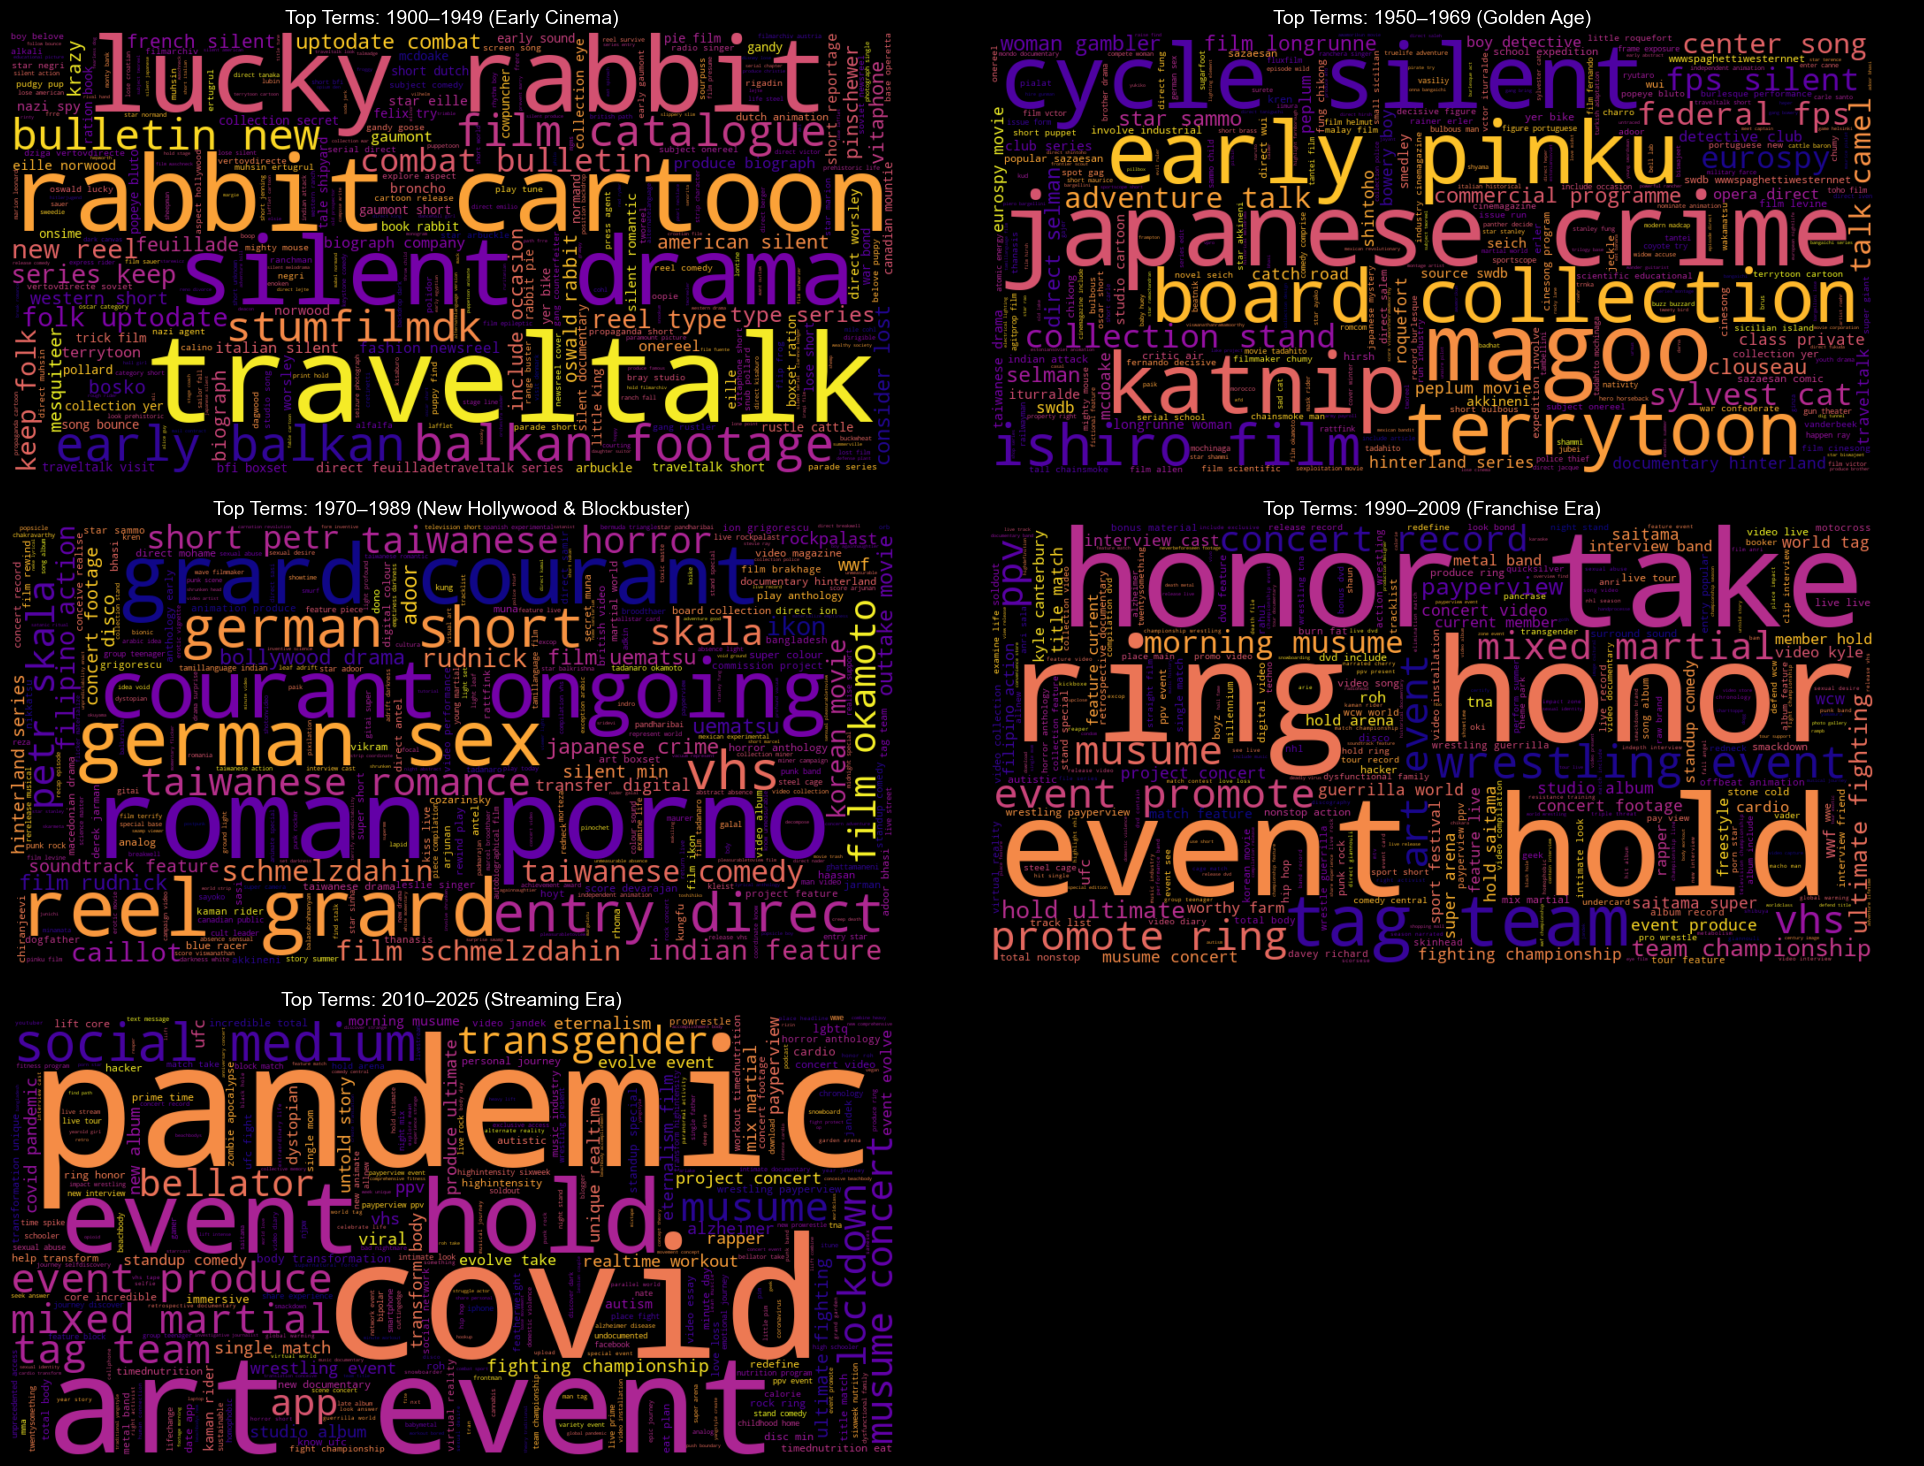

In [41]:
def plot_wordclouds_per_period(tfidf_dict, max_words=350, cols=2):
    periods = list(tfidf_dict.keys())
    rows = (len(periods) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 5), facecolor='black')
    axes = axes.flatten()

    for idx, (period, scores) in enumerate(tfidf_dict.items()):
        wc = WordCloud(
            width=1000,
            height=500,
            max_words=max_words,
            background_color='black',
            prefer_horizontal=0.6,
            relative_scaling=0.3,
            colormap='plasma'
        )
        wc.generate_from_frequencies(scores)
        axes[idx].imshow(wc, interpolation="bilinear")
        axes[idx].axis("off")
        axes[idx].set_title(f"Top Terms: {period}", fontsize=14, color='white')

    for j in range(len(periods), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_wordclouds_per_period(filtered_top, max_words=350, cols=2)

### Analysis 1: Temporal Keyword Trends

This analysis investigates how language and dominant themes in movie overviews have changed over time. The word clouds above visualize the top TF-IDF-scored terms for each of five historical eras:

- **1900–1949 (Early Cinema)**
- **1950–1969 (Golden Age)**
- **1970–1989 (New Hollywood & Blockbuster)**
- **1990–2009 (Franchise Era)**
- **2010–2025 (Streaming Era)**

#### Method Summary

The analysis follows these key steps:

1. **Text Cleaning**: The `overview` field was lowercased, stripped of stopwords, lemmatized, and filtered via `should_filter_tkt()` to remove generic, short, or non-informative terms.

2. **Temporal Grouping**: Using the `time_bins` dictionary, all movie overviews were grouped into 5 time-based bins.

3. **TF-IDF Scoring**: Each period's tokenized text was vectorized using a `TfidfVectorizer` (with both unigrams and bigrams), calculating how representative each term is for that time period.

4. **Filtering**:
   - Generic terms that appeared in more than 3 time bins were removed (`filter_common_terms()`).
   - Only the top 300 terms per bin were kept (`get_top_n_terms()`).

5. **Visualization**:
   - The `plot_wordclouds_per_period()` function created a set of styled word clouds, where term size reflects its relative TF-IDF weight in that era.
   - Color intensity helps to visually highlight dominant terms.

#### Observation

- **1900–1949 (Early Cinema)**:
  Dominated by terms like **travel talk, cartoon, silent, and rabbit**, reflecting early experimental forms like travelogues, animation (e.g. **Lucky Rabbit**), and silent films.

- **1950–1969 (Golden Age)**:
  Representative terms like **magoo, katnip, cartoon, and japanese** reflect the global rise of animated shorts (**Mr. Magoo**, **Katnip the Cat**) and increased international influence, especially from Japan (**pinku**, **crime**, **Ishiro**). The presence of terms like **cycle** and **collection** suggests the structured release of genre films and growing home media or archive curation. The era blends classic Hollywood storytelling with the emergence of global niche cinema.

- **1970–1989 (New Hollywood & Blockbuster)**:
  Dominated by terms like **german, courant, porn, and short**, this era reflects a growing presence of European film influences (**courant**, **german**), adult-themed content (**porn**), and experimental short formats. It suggests a blend of boundary-pushing storytelling and global crossover.

- **1990–2009 (Franchise Era)**:
  Strongly shaped by terms such as **honor, take, promote, and wrestling**, this period emphasizes action-driven franchises, marketing-heavy productions, and combat-sport influences, with clear connections to pro wrestling and mixed martial arts as recurring cultural motifs.

- **2010–2025 (Streaming Era)**:
  Highly topical terms like **pandemic, covid, social media, transgender**, and **art** dominate, reflecting both global events (COVID-19) and increased representation and diversity in streaming-era content.

#### Interpretation

The analysis highlights a clear shift in **language** and **thematic focus** across different cinematic eras. While **early film periods** were characterized by **technical and formal experimentation** (e.g., *silent films*, *animation*), later decades are dominated by themes such as **franchise development**, **global cultural influences**, and **sociopolitical topics**.

Especially in the **Streaming Era**, there is a strong emphasis on **current discourses** like **the pandemic**, **diversity**, and **digital media**, reflecting a broader **cultural transformation** within the film industry.

---

## Analysis 2: Inter-Genre Similarity Analysis

### Custom Term Filtering for NLP Analysis

The `should_filter_igsa` function applies advanced filtering to candidate terms (unigrams or bigrams) before they are included in the genre-specific TF-IDF analysis.

This function helps remove **non-generic but non-informative** terms by checking for:

- **Named entities** such as people, organizations, places, products, or titles (detected using spaCy’s NER),
- **Proper noun-dominant phrases**, including POS patterns like `"PROPN NOUN"` or `"ADJ PROPN"`, which often indicate specific names.

By excluding these terms, the function ensures that the genre similarity analysis focuses on **generalizable, content-relevant language patterns**, rather than on specific names or entities. This is a crucial pre-step for inter-genre similarity analysis.

In [44]:
def should_filter_igsa(term, blacklist):
    doc = nlp(term)
    pos_tags = [token.pos_ for token in doc]

    return (
        any(ent.label_ in {"PERSON", "ORG", "GPE", "WORK_OF_ART", "PRODUCT", "EVENT"} for ent in doc.ents) or
        (all(p == "PROPN" for p in pos_tags) or pos_tags in [["PROPN", "NOUN"], ["ADJ", "PROPN"]]) or
        term.lower() in blacklist
    )

### Identifying Genre-Independent Terms: Unigrams & Bigrams

The following code cells define two functions that help identify **commonly occurring terms** (unigrams and bigrams) across multiple genres using **TF-IDF scores**.
The idea is to find **generic or genre-neutral phrases** that appear frequently in different genre texts, which can later be **filtered out** to focus on more distinctive, genre-specific language.

#### Build Generic Unigrams

This function extracts the **top unigrams (single words)** from each genre-specific document using TF-IDF.
It collects the most important terms per document and counts how often they appear across all genres.

In [45]:
def build_generic_unigrams(documents, config):
    vec = TfidfVectorizer(
        ngram_range=(1, 1),
        stop_words='english',
        min_df=config['min_df'],
        max_df=config['max_df_unigrams']
    )

    X = vec.fit_transform(documents)
    terms = vec.get_feature_names_out()
    counter = Counter()

    for row in X.toarray():
        top_indices = row.argsort()[::-1][:config['unigram_top_n']]
        counter.update([terms[i] for i in top_indices])

    return {term for term, count in counter.items() if count >= config['min_genres']}

#### Build Cross Genre Bigrams

Similar to the unigram function, this function focuses on **bigrams (two-word phrases)**.
It identifies the most relevant bigrams in each genre document, using TF-IDF scores, and tracks how often they occur across genres.

In [46]:
def build_cross_genre_bigrams(documents, config):
    vec = TfidfVectorizer(
        ngram_range=(2, 2),
        stop_words='english',
        min_df=config['min_df'],
        max_df=config['max_df_bigrams']
    )

    X = vec.fit_transform(documents)
    terms = vec.get_feature_names_out()
    counter = Counter()

    for row in X.toarray():
        top_indices = row.argsort()[::-1][:config['bigram_top_n']]
        counter.update([terms[i] for i in top_indices])

    return {term for term, count in counter.items() if count >= config['min_genres']}

### Genre-Level TF-IDF Vectorization

The `igsa_tfidf_analysis` function performs the core TF-IDF computation across movie genres. Each genre is represented by a concatenated document of all its movie overviews. This step lays the foundation for identifying the most characteristic terms per genre.

Key operations:

- **Stopword control**: For unigrams, both default and automatically detected stopwords are removed. For bigrams, stopword filtering is skipped to preserve important multi-word expressions.
- **TF-IDF vectorization**: Applies `TfidfVectorizer` using settings from the configuration object (`CONFIG`) and the specified `ngram_range` (either unigrams or bigrams).
- **Term filtering**: After scoring terms per genre, results are filtered using `should_filter_igsa()` to remove named entities, proper names, and cross-genre generic terms.
- **Top-N selection**: Only the top `N` terms per genre are kept (as defined in the config: `top_terms_per_genre`).

This process prepares the cleaned, high-signal keyword lists that will be used in the **TF-IDF Keyword Extraction and Display by Genre**, a key step in the **Inter-Genre Similarity Analysis**.

In [47]:
def igsa_tfidf_analysis(documents, genre_names, config, auto_stopwords, cross_genre_blacklist, ngram_range):
    combined_stopwords = list(ENGLISH_STOP_WORDS.union(auto_stopwords)) if ngram_range == (1, 1) else None
    max_df = config['max_df_unigrams'] if ngram_range == (1, 1) else config['max_df_bigrams']

    vectorizer = TfidfVectorizer(
        stop_words=combined_stopwords,
        ngram_range=ngram_range,
        min_df=config['min_df'],
        max_df=max_df
    )
    X = vectorizer.fit_transform(documents)
    terms = vectorizer.get_feature_names_out()
    results = []

    for idx, genre in enumerate(genre_names):
        row = X[idx].toarray()[0]
        top_indices = row.argsort()[::-1]
        filtered = []

        for i in top_indices:
            term = terms[i]
            score = row[i]
            if not should_filter_igsa(term, cross_genre_blacklist):
                filtered.append((term, score))
            if len(filtered) == config['top_terms_per_genre']:
                break

        results.append((genre, filtered))

    return results

### Preparing Genre-Specific Text Corpora

The `prepare_genre_documents` function builds the input needed for genre-level TF-IDF analysis. It aggregates cleaned movie overviews (`overview_clean`) by genre, resulting in one large document per genre.

Key steps:

- Filters out movies with missing genre information.
- Splits the genre string into a list (assuming `'-'` is the delimiter for multiple genres).
- Groups and concatenates all preprocessed overviews (`overview_clean`) for each genre.
- Returns:
  - A list of genre names.
  - A corresponding list of genre-level aggregated text documents.

This function provides the **input documents and genre labels** required for the **TF-IDF Keyword Extraction and Display by Genre**, which forms the basis for comparing genres in the **Inter-Genre Similarity Analysis**.

In [48]:
def prepare_genre_documents(df):
    df_genres = df[df['genres'].notna()].copy()

    df_genres['genre_list'] = df_genres['genres'].str.split('-')

    genre_texts = defaultdict(list)

    for _, row in df_genres.iterrows():
        if pd.isna(row['overview_clean']):
            continue
        for genre in row['genre_list']:
            genre_texts[genre].append(row['overview_clean'])

    genre_corpus = {genre: ' '.join(texts) for genre, texts in genre_texts.items()}

    return list(genre_corpus.keys()), list(genre_corpus.values())

### TF-IDF Keyword Extraction and Display by Genre

This step builds on the earlier-prepared **genre-specific corpora**, **automatic stopword detection**, and **TF-IDF analysis functions**.

The code performs the following:

- Applies the previously defined `igsa_tfidf_analysis()` function to compute the top-scoring **unigrams** and **bigrams** for each genre.
- Converts the results into pandas DataFrames, rounds the TF-IDF scores for better readability, and combines unigrams and bigrams side by side.
- Uses interactive `Accordion` widgets (via `IPython.display`) to display the results per genre in a clean and expandable format.

Each genre's panel shows its most distinctive terms, based on genre-specific TF-IDF scores. This serves as the final output of the **TF-IDF Keyword Extraction** phase and provides the semantic foundation for analyzing genre similarities in the next steps of the **Inter-Genre Similarity Analysis**.

In [50]:
genre_names, genre_documents = prepare_genre_documents(df_all)

auto_stopwords = build_generic_unigrams(genre_documents, CONFIG)
cross_genre_blacklist = build_cross_genre_bigrams(genre_documents, CONFIG)

unigrams_with_scores = igsa_tfidf_analysis(
    genre_documents, genre_names, CONFIG, auto_stopwords, cross_genre_blacklist, (1, 1)
)
bigrams_with_scores = igsa_tfidf_analysis(
    genre_documents, genre_names, CONFIG, auto_stopwords, cross_genre_blacklist, (2, 2)
)

for (genre_u, unigrams), (_, bigrams) in zip(unigrams_with_scores, bigrams_with_scores):
    df_uni = pd.DataFrame(unigrams, columns=['Unigram', 'Score'])
    df_bi = pd.DataFrame(bigrams, columns=['Bigram', 'Score'])

    df_uni['Score'] = df_uni['Score'].round(4)
    df_bi['Score'] = df_bi['Score'].round(4)

    combined_df = pd.concat([df_uni, df_bi], axis=1)

    out = Output()
    with out:
        display(combined_df)

    acc = Accordion(children=[out])
    acc.set_title(0, f"Genre: {genre_u}")
    display(acc)

Accordion(children=(Output(),), titles=('Genre: Action',))

Accordion(children=(Output(),), titles=('Genre: Science Fiction',))

Accordion(children=(Output(),), titles=('Genre: Horror',))

Accordion(children=(Output(),), titles=('Genre: Mystery',))

Accordion(children=(Output(),), titles=('Genre: Thriller',))

Accordion(children=(Output(),), titles=('Genre: Comedy',))

Accordion(children=(Output(),), titles=('Genre: Adventure',))

Accordion(children=(Output(),), titles=('Genre: Drama',))

Accordion(children=(Output(),), titles=('Genre: Animation',))

Accordion(children=(Output(),), titles=('Genre: Family',))

Accordion(children=(Output(),), titles=('Genre: Fantasy',))

Accordion(children=(Output(),), titles=('Genre: History',))

Accordion(children=(Output(),), titles=('Genre: War',))

Accordion(children=(Output(),), titles=('Genre: Crime',))

Accordion(children=(Output(),), titles=('Genre: Romance',))

Accordion(children=(Output(),), titles=('Genre: Documentary',))

Accordion(children=(Output(),), titles=('Genre: Music',))

Accordion(children=(Output(),), titles=('Genre: TV Movie',))

Accordion(children=(Output(),), titles=('Genre: Western',))

### Interpretation of Genre-Based TF-IDF Output

Each collapsible section represents a movie **genre** and contains a ranked list of the **top 40 unigrams and bigrams** extracted from movie overviews using **TF-IDF** scoring. These terms highlight the most **distinctive and genre-specific language** used in film descriptions. The scores reflect the **relative importance** of each term within its genre, while generic and named-entity terms are filtered out using **linguistic heuristics** (e.g., POS tagging, NER, cross-genre frequency).

### Genre Vectorization and Similarity Computation

This code constructs numeric vectors for each genre based on its top TF-IDF-scored unigrams and bigrams, and then computes the **semantic similarity** between all genre pairs.

#### Key Steps:

- **Vocabulary Construction**:
  A global `vocab` is created by collecting all unique unigrams and bigrams across all genres.

- **Vector Representation**:
  For each genre, a feature vector is created using the function `vectorize_combined()`. Each element in the vector represents the summed TF-IDF score of a term (from both unigram and bigram dictionaries).

- **Similarity Calculation**:
  Using `cosine_similarity()`, the pairwise similarity between all genre vectors is computed, producing a square similarity matrix.

- **Hierarchical Clustering**:
  A `linkage_matrix` is created based on the similarity distances (`1 - cosine similarity`) using Ward's method.
  This is then used to generate an **ordered list of genres** (`ordered_genres`) for visualization purposes.

The resulting similarity matrix and clustering order reflect **how semantically close or distant genres are**, based on their most distinctive terms. This prepares the data for the final visualization in the **Genre Similarity Heatmap**.

In [51]:
genre_unigram_dict = {genre: dict(terms) for genre, terms in unigrams_with_scores}
genre_bigram_dict = {genre: dict(terms) for genre, terms in bigrams_with_scores}

all_terms = set()
for genre in genre_unigram_dict.keys():
    all_terms.update(genre_unigram_dict[genre].keys())
    all_terms.update(genre_bigram_dict.get(genre, {}).keys())
vocab = sorted(all_terms)

def vectorize_combined(genre, vocab, unigram_dict, bigram_dict):
    u_scores = unigram_dict.get(genre, {})
    b_scores = bigram_dict.get(genre, {})
    return np.array([u_scores.get(t, 0.0) + b_scores.get(t, 0.0) for t in vocab])

genre_names = list(genre_unigram_dict.keys())
vectors = np.array([vectorize_combined(genre, vocab, genre_unigram_dict, genre_bigram_dict) for genre in genre_names])

if np.any(np.all(vectors == 0, axis=1)):
    print("Warning: Some genres have zero vectors, which may affect similarity calculation.")

similarity_matrix = cosine_similarity(vectors)

linkage_matrix = linkage(1 - similarity_matrix, method='ward')
ordered_indices = leaves_list(linkage_matrix)

ordered_genres = [genre_names[i] for i in ordered_indices]
ordered_similarity_matrix = similarity_matrix[ordered_indices, :][:, ordered_indices]

### Visualization: Genre Similarity as a Heatmap

This code visualizes the **pairwise similarity between movie genres** using a heatmap. The similarity is based on the combined TF-IDF vectors of unigrams and bigrams, as computed in the previous step.

#### Key Features:

- **Input**: Uses the `ordered_similarity_matrix` and `ordered_genres`, which were sorted via hierarchical clustering to group semantically similar genres closer together.
- **Visualization**:
  - A `seaborn.heatmap` displays similarity scores between genres (0 to 1, where 1 = identical).
  - Colors range from cool to warm, indicating lower to higher similarity.
  - Values are annotated in each cell with two decimal places for clarity.
- **Styling**:
  - Axes labels are rotated and sized for readability.
  - Square cells and grid lines help clearly separate genre pairs.

This heatmap provides an **intuitive overview of semantic relationships** between genres based on language use in movie overviews, the central visual output of the **Inter-Genre Similarity Analysis**.

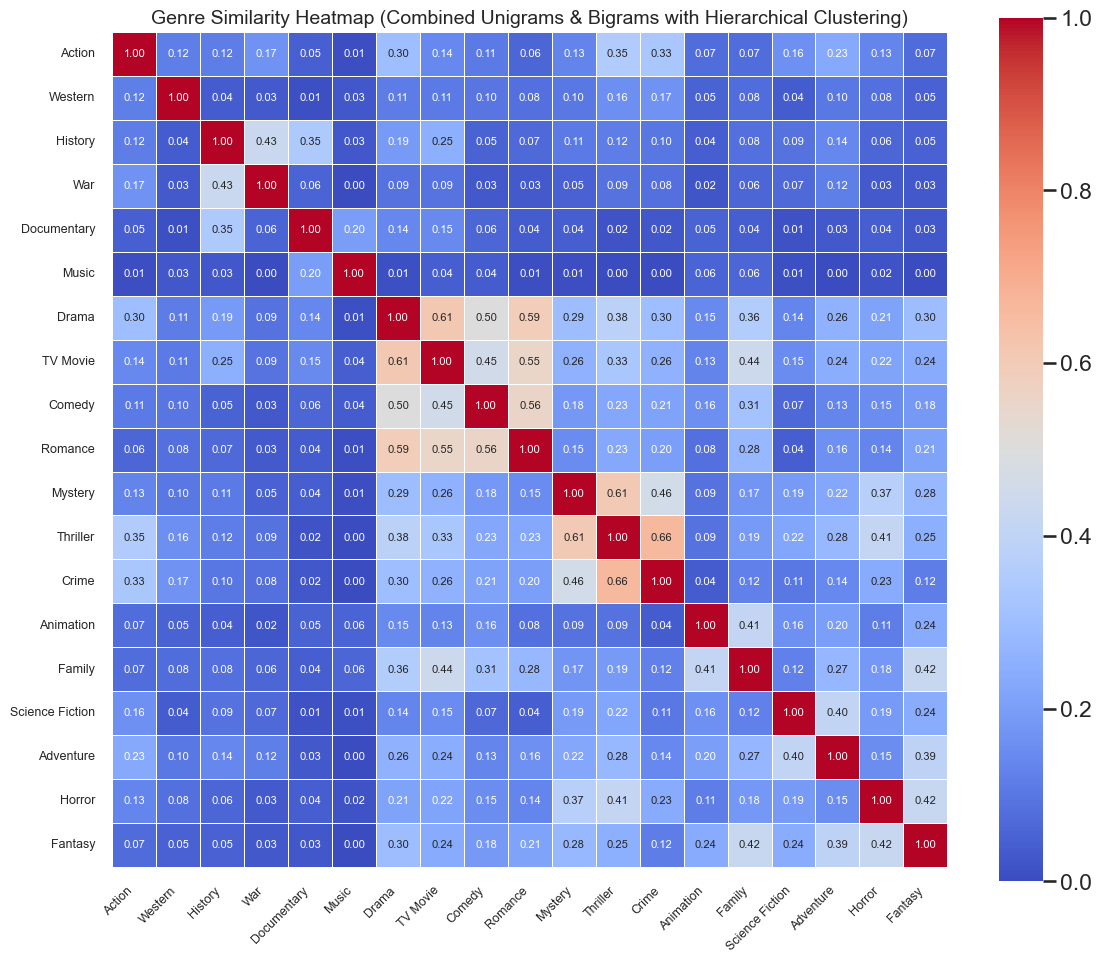

In [52]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    ordered_similarity_matrix,
    xticklabels=ordered_genres,
    yticklabels=ordered_genres,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)

plt.title("Genre Similarity Heatmap (Combined Unigrams & Bigrams with Hierarchical Clustering)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

### Analysis 2: Inter-Genre Similarity Analysis

The heatmap above visualizes the **semantic similarity between movie genres** based on the language used in their plot summaries (`overview_clean`). Each genre is represented by a combined TF-IDF vector of its most distinctive unigrams and bigrams.

#### Method Summary

1. **Preprocessing**: Movie overviews were first **lowercased**, **lemmatized**, and **filtered** to remove stopwords and irrelevant tokens.

2. **Genre Document Construction**: For each genre, all related overviews were **merged into a single document** using `prepare_genre_documents()`.

3. **TF-IDF Calculation**: TF-IDF scores were computed for **unigrams** and **bigrams** using `igsa_tfidf_analysis()`. A custom filter `should_filter_igsa()` was applied to remove **named entities** and **genre-agnostic terms**.

4. **Genre Vectorization**: The **top-scoring TF-IDF terms** were used to build a **combined feature vector** for each genre via `vectorize_combined()`.

5. **Similarity Computation**: **Cosine similarity** was calculated between genre vectors to assess pairwise semantic similarity.

6. **Clustering & Reordering**: Genres were **reordered using hierarchical clustering** (Ward method) to reveal **semantic groupings** based on content overlap.

#### Observations

- **Highly Similar Genres**:
  - *Thriller* and *Crime* (similarity: 0.66)
  - *Drama* and *Romance* (0.59)
  - *Thriller* and *Mystery* (0.61)
  - *TV Movie* and *Drama* (0.61)

  These pairings reflect clear thematic overlap, as they often share similar narrative structures, emotional tones, or subject matter.

- **Genre Clusters**:
  - The upper middle of the heatmap shows a tightly clustered block including *Drama*, *TV Movie*, *Romance*, *Mystery*, and *Thriller*, genres often grounded in character-driven or suspenseful storytelling.
  - *Documentary*, *History*, and *War* appear near each other, suggesting shared factual or historical terminology.

- **Outlier or Distinct Genres**:
  - *Western*, *Music*, and *Fantasy* show relatively low similarity scores with most other genres, indicating more **genre-specific vocabulary** or thematic isolation.
  - *Animation* and *Family* are moderately aligned with each other (0.41), which fits well with their frequent co-occurrence in children’s and family entertainment.

#### Interpretation

The resulting similarity structure illustrates how **shared linguistic patterns** mirror broader thematic connections across genres. Clusters of semantically aligned genres suggest a common **narrative and stylistic core**, while isolated genres stand out due to their **distinctive language use**.

These patterns reflect how genres position themselves in terms of **tone, subject matter**, and **audience expectations**, offering insight into the semantic space of overall cinema.